Alex Verbs, Kristina Schaufele, Reese Wolfe 

In [13]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import load_model
from tensorflow.keras import regularizers, applications, models,layers, optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam



# Loading the Data:

In [8]:
# Define a Keras Sequential model for data augmentation
data_augmentation = tf.keras.Sequential([
    layers.Resizing(224, 224),  # Resize to 224x224
    layers.RandomFlip("horizontal"),  # Random horizontal flip
    layers.RandomRotation(0.1),  # Random rotation up to 10 degrees
    layers.RandomBrightness(0.2),  # Adjust brightness
    layers.RandomContrast(0.2),  # Adjust contrast
    layers.RandomTranslation(0, 0.1),  # Random shear (approximates affine transformations)
    layers.Rescaling(1./255),  # Rescale the pixel values to [0, 1]
    layers.Normalization(mean=[0.485, 0.456, 0.406], variance=[0.229**2, 0.224**2, 0.225**2])  # Normalize with ImageNet mean/std
])

# Directory and dataset names
imageDir = "data"
datasets = ['Testing', 'Training']

# Number of augmented images to create for each original image (only 1 here since we're just flipping horizontally)
num_augmentations = 1

# Iterate over each dataset
for dataset in datasets:
    dataset_path = os.path.join(imageDir, dataset)
    if not os.path.isdir(dataset_path):
        continue
    
    # Only augment images in the 'Training' dataset
    if dataset == 'Training':
        # Get all tumor type directories within the dataset directory
        tumor_types = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
        for tumor_type in tumor_types:
            tumor_path = os.path.join(dataset_path, tumor_type)
            
            # List all files (images) in the tumor type directory
            images = [f for f in os.listdir(tumor_path) if os.path.isfile(os.path.join(tumor_path, f))]
            
            for image_file in images:
                image_path = os.path.join(tumor_path, image_file)
                
                # Load and process the image
                original_image = tf.keras.preprocessing.image.load_img(image_path)
                original_image_array = tf.keras.preprocessing.image.img_to_array(original_image)
                original_image_array = tf.expand_dims(original_image_array, 0)  # Add batch dimension
                
                # Generate a horizontally flipped image
                augmented_image_array = data_augmentation(original_image_array)
                augmented_image = tf.keras.preprocessing.image.array_to_img(augmented_image_array[0])
                
                # Define path for saving augmented image
                augmented_image_path = os.path.join(tumor_path, f"flip_{image_file}")
                augmented_image.save(augmented_image_path)
                
                print(f"Augmented image created for {image_file} in {tumor_type}")




Horizontally flipped image created for aug_6_Tr-pi_1355.jpg in pituitary
Horizontally flipped image created for flip_Tr-pi_0013_rot270.png in pituitary
Horizontally flipped image created for aug_8_Tr-pi_0491_rot270.png in pituitary
Horizontally flipped image created for aug_2_Tr-pi_0120_rot180.png in pituitary
Horizontally flipped image created for Tr-pi_1368_rot90.png in pituitary
Horizontally flipped image created for aug_0_Tr-pi_0097_rot270.png in pituitary
Horizontally flipped image created for flip_aug_7_Tr-pi_0897.jpg in pituitary
Horizontally flipped image created for aug_8_Tr-pi_0860_rot90.png in pituitary
Horizontally flipped image created for flip_aug_6_Tr-pi_0515.jpg in pituitary
Horizontally flipped image created for Tr-pi_1270_rot180.png in pituitary
Horizontally flipped image created for aug_8_Tr-pi_0311_rot180.png in pituitary
Horizontally flipped image created for aug_0_Tr-pi_0717_rot180.png in pituitary
Horizontally flipped image created for aug_0_Tr-pi_0851.jpg in pit

KeyboardInterrupt: 


Dataset: Testing
  Tumor Type: pituitary, Number of images: 12568
  Tumor Type: notumor, Number of images: 16200
  Tumor Type: glioma, Number of images: 12000
  Tumor Type: meningioma, Number of images: 12240

Dataset: Training
  Tumor Type: pituitary, Number of images: 35171
  Tumor Type: notumor, Number of images: 6380
  Tumor Type: glioma, Number of images: 5284
  Tumor Type: meningioma, Number of images: 2182


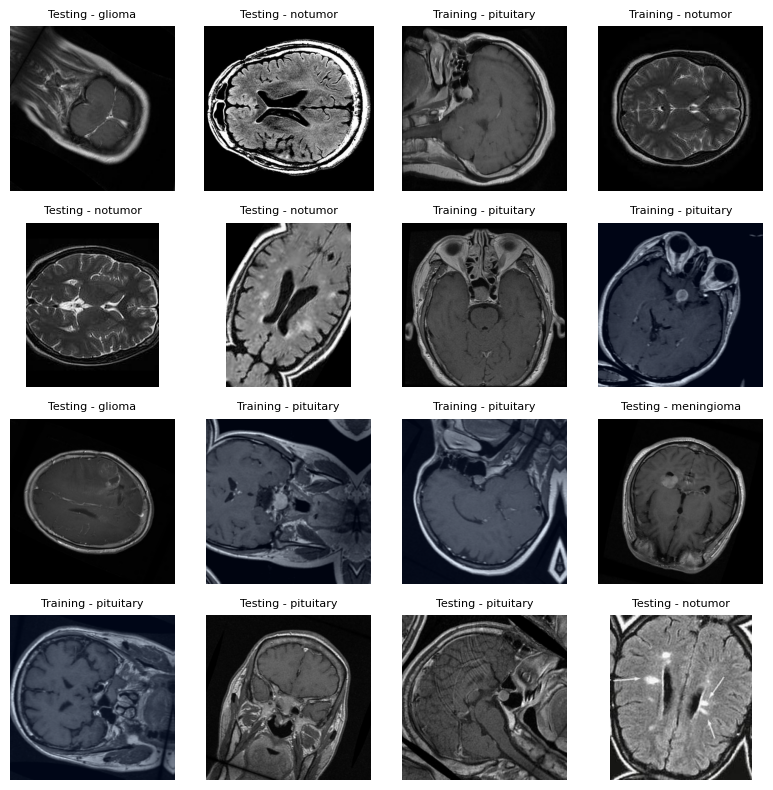

In [14]:
import random

# Collect sample images and their labels
sample_images = []
labels = []


# Define data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal")
])

for dataset in datasets:
    dataset_path = os.path.join(imageDir, dataset)
    if not os.path.isdir(dataset_path):
        print(f"Dataset directory not found: {dataset_path}")
        continue  # Skip if the dataset directory does not exist
    print(f"\nDataset: {dataset}")
    
    # Get all tumor type directories within the dataset directory
    tumor_types = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    for tumor_type in tumor_types:
        tumor_path = os.path.join(dataset_path, tumor_type)
        
        # List all files (images) in the tumor type directory
        images = [f for f in os.listdir(tumor_path) if os.path.isfile(os.path.join(tumor_path, f))]
        num_images = len(images)
        
        print(f"  Tumor Type: {tumor_type}, Number of images: {num_images}")
        
        if num_images == 0:
            print(f"  No images found in {tumor_path}")
            continue  # Skip to the next tumor type if no images are found
        
        # Add all images from each tumor type to the sample lists
        for image_file in images:
            image_path = os.path.join(tumor_path, image_file)
            sample_images.append(image_path)
            labels.append(f"{dataset} - {tumor_type}")

# Randomize the collected images
combined_data = list(zip(sample_images, labels))
random.shuffle(combined_data)

# Limit to 16 random images
sample_images, labels = zip(*combined_data[:16])

# Display images in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(8, 8))  # Adjust figsize to make images smaller or larger
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for idx, ax in enumerate(axes):
    if idx < len(sample_images):
        image_path = sample_images[idx]
        img = mpimg.imread(image_path)
        ax.imshow(img, cmap='gray')
        ax.set_title(labels[idx], fontsize=8)
        ax.axis('off')
    else:
        ax.axis('off')  # Hide any unused subplots

plt.tight_layout()
plt.show()

In [15]:
# Parameters
img_height = 180  # Set your desired image height
img_width = 180   # Set your desired image width
batch_size = 32   # Set your desired batch size

# Directory paths for training and testing
train_dir = "data/Training"
test_dir = "data/Testing"

# Load the training dataset
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load the testing dataset
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 49017 files belonging to 4 classes.
Found 53008 files belonging to 4 classes.


# Baseline Accuracy

In [16]:

class_counts = {'notumor': 0, 'glioma': 0, 'meningioma': 0, 'pituitary': 0}
dataset_path = os.path.join(imageDir, 'Training')

print(f"\nDataset: {'Training'}")
print(f"")

# Get all tumor type directories within the dataset directory
tumor_types = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
for tumor_type in tumor_types:
    tumor_path = os.path.join(dataset_path, tumor_type)
    
    # List all files (images) in the tumor type directory
    images = [f for f in os.listdir(tumor_path) if os.path.isfile(os.path.join(tumor_path, f))]
    num_images = len(images)
    
        # Adjust class names as per your folder names
    if "notumor" in tumor_type:
        class_counts['notumor'] += num_images
    elif "glioma" in tumor_type:
        class_counts['glioma'] += num_images
    elif "meningioma" in tumor_type:
        class_counts['meningioma'] += num_images
    elif "pituitary" in tumor_type:
        class_counts['pituitary'] += num_images

    # Print the class counts before calculating baseline accuracy
print("Class Counts:", class_counts)

# Calculate baseline accuracy for subtypes
total_images = class_counts['notumor'] + class_counts['glioma'] + class_counts['meningioma'] + class_counts['pituitary']
majority_class_count = max(class_counts.values())
baseline_accuracy = majority_class_count / total_images

print(f"Baseline Accuracy for 4 Categories: {baseline_accuracy:.2%}")

# Calculate baseline accuracy for subtypes
total_tumors = class_counts['glioma'] + class_counts['meningioma'] + class_counts['pituitary']
no_tumors = class_counts['notumor']
binary_baseline_accuracy = total_tumors/ total_images
print(f"Baseline Accuracy for 2 Categories: {binary_baseline_accuracy:.2%}")



Dataset: Training

Class Counts: {'notumor': 6380, 'glioma': 5284, 'meningioma': 2182, 'pituitary': 35171}
Baseline Accuracy for 4 Categories: 71.75%
Baseline Accuracy for 2 Categories: 86.98%


# Transfer learning with ResNet

In [17]:
# Load a pretrained ResNet50 model, excluding the top layer
base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze all layers initially

# mark loaded layers as not trainable
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Resizing(224, 224),  # ResNet50 expects 224x224 images
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(4, activation='softmax')  # Final layer with softmax for classification
])


# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate= 0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5
)

# Evaluate the model
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



Epoch 1/5
 274/1532 ━━━━━━━━━━━━━━━━━━━━ 20:39 985ms/step - accuracy: 0.8586 - loss: 1.6834

2024-11-18 19:01:58.095105: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 386/1532 ━━━━━━━━━━━━━━━━━━━━ 18:25 964ms/step - accuracy: 0.8757 - loss: 1.3441

2024-11-18 19:03:40.332688: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 975/1532 ━━━━━━━━━━━━━━━━━━━━ 8:47 948ms/step - accuracy: 0.9075 - loss: 0.7451

2024-11-18 19:12:52.132215: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1038/1532 ━━━━━━━━━━━━━━━━━━━━ 13:47 2s/step - accuracy: 0.9089 - loss: 0.7179

2024-11-18 19:26:25.413628: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at whole_file_read_ops.cc:116 : DEADLINE_EXCEEDED: data/Training/meningioma/Tr-me_0222_rot180.png; Operation timed out
2024-11-18 19:26:25.569410: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at whole_file_read_ops.cc:116 : DEADLINE_EXCEEDED: data/Training/glioma/Tr-gl_0781_rot180.png; Operation timed out


1040/1532 ━━━━━━━━━━━━━━━━━━━━ 13:43 2s/step - accuracy: 0.9090 - loss: 0.7171

2024-11-18 19:26:29.707304: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at whole_file_read_ops.cc:116 : DEADLINE_EXCEEDED: data/Training/notumor/Tr-no_0688_rot90.png; Operation timed out


1042/1532 ━━━━━━━━━━━━━━━━━━━━ 13:39 2s/step - accuracy: 0.9090 - loss: 0.7163

2024-11-18 19:26:31.388256: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at whole_file_read_ops.cc:116 : DEADLINE_EXCEEDED: data/Training/glioma/Tr-gl_0041_rot270.png; Operation timed out


1056/1532 ━━━━━━━━━━━━━━━━━━━━ 13:11 2s/step - accuracy: 0.9093 - loss: 0.7106

2024-11-18 19:26:43.733757: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: DEADLINE_EXCEEDED: data/Training/meningioma/Tr-me_0222_rot180.png; Operation timed out
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]]


DeadlineExceededError: Graph execution error:

Detected at node ReadFile defined at (most recent call last):
<stack traces unavailable>
data/Training/meningioma/Tr-me_0222_rot180.png; Operation timed out
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_4774392]